In [1]:
import numpy as np
import torch
import os
import jinja2
from PIL import Image
import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)

import sys
sys.path.append('/home/siyi/master/clip/CLIP')

import clip
print("Available models:", clip.available_models())

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Torch version: 2.0.0+cu117
Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [21]:
# Zero-Shot Image Classification
# defect_types = ["good", "crack", "spall", "spatter", "chip", "hole"]
# defect_descriptions = [
#     f"This is a good picture." if defect_type == "good" else f"This is a bad picture with a {defect_type} defect."
#     for defect_type in defect_types
# ]

defect_descriptions = [
    "A photo of a good cashew",
    "A photo of a defect cashew",
    "A photo of a good clip",
    "A photo of a defect clip",
]

In [22]:
# Tokenize the text descriptions
text_tokens = clip.tokenize(defect_descriptions).cuda()

In [4]:
# Define the directory for images and list image files
img_dir = "../defect_data/"
image_files = [f"{img_dir}{img_name}" for img_name in os.listdir(img_dir) if img_name.endswith(('.png', '.jpg', '.jpeg'))]

In [5]:
def load_and_preprocess_images(image_files):
    images = []
    for img_file in image_files:
        image = Image.open(img_file).convert("RGB")
        images.append(preprocess(image).unsqueeze(0))  # 添加批次维度
    return torch.cat(images, dim=0).cuda()  # 合并为一个批次并移动到GPU

In [6]:
images = load_and_preprocess_images(image_files)

In [7]:
with torch.no_grad():
    image_features = model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

In [23]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(4, dim=-1)

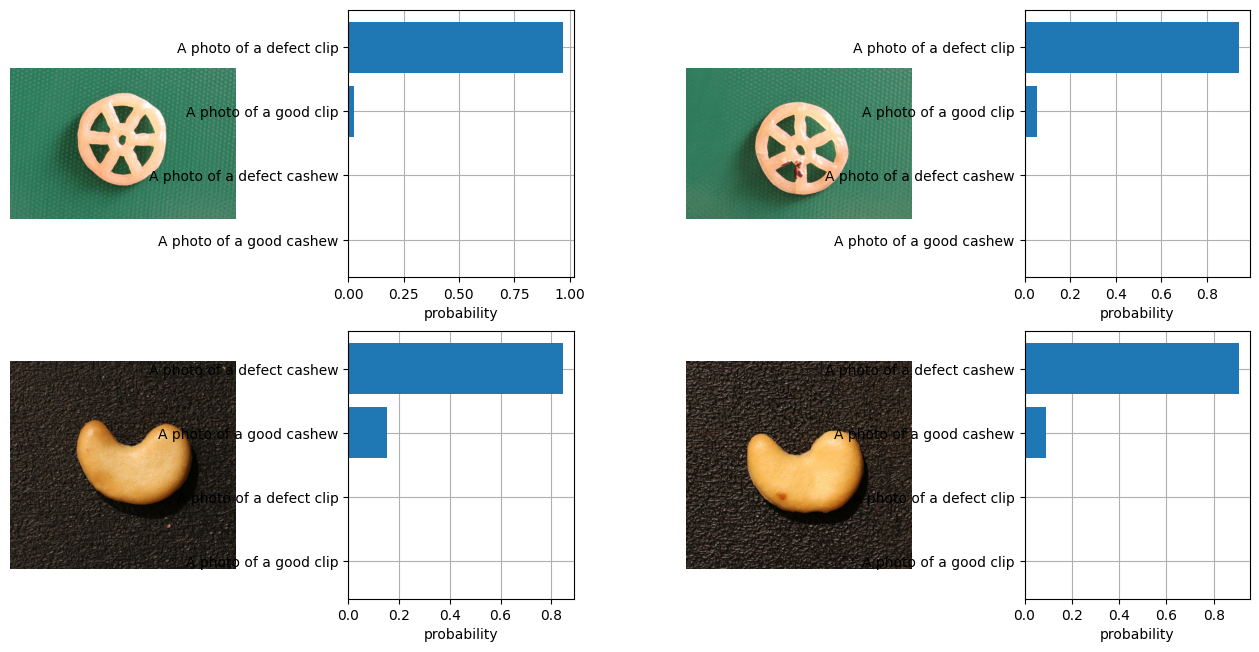

In [24]:
# Visualize results
plt.figure(figsize=(16, 16))

for i, img_file in enumerate(image_files):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(Image.open(img_file))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [defect_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# 直接应用CLIP的问题
# CLIP的粒度太小了，对缺陷的描述能力有限，对对象分类还是不错的。但是我们检测还是需要细粒度的。